In [298]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [299]:
# Define la ruta del directorio de datos
root = '../../Laboratories/Lab05/datasets/CelebAGaze'

# Define las transformaciones de datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2.) - 1.)
])

# Cargar datos de entrenamiento
train_dataset = ImageFolder(root=root, transform=transform)

# Obtener el número total de ejemplos
total_samples = len(train_dataset)

# Inicializar matrices X e Y
X = torch.empty((total_samples, 3, 64, 64))
Y = torch.empty(total_samples, dtype=torch.long)

# Llenar las matrices X e Y
for i in range(total_samples):
    img, label = train_dataset[i]
    X[i] = img
    Y[i] = label

# Verificar las dimensiones de X e Y
print(X.shape, Y.shape)

Dimensiones de X: torch.Size([20000, 3, 64, 64])
Dimensiones de Y: torch.Size([20000])


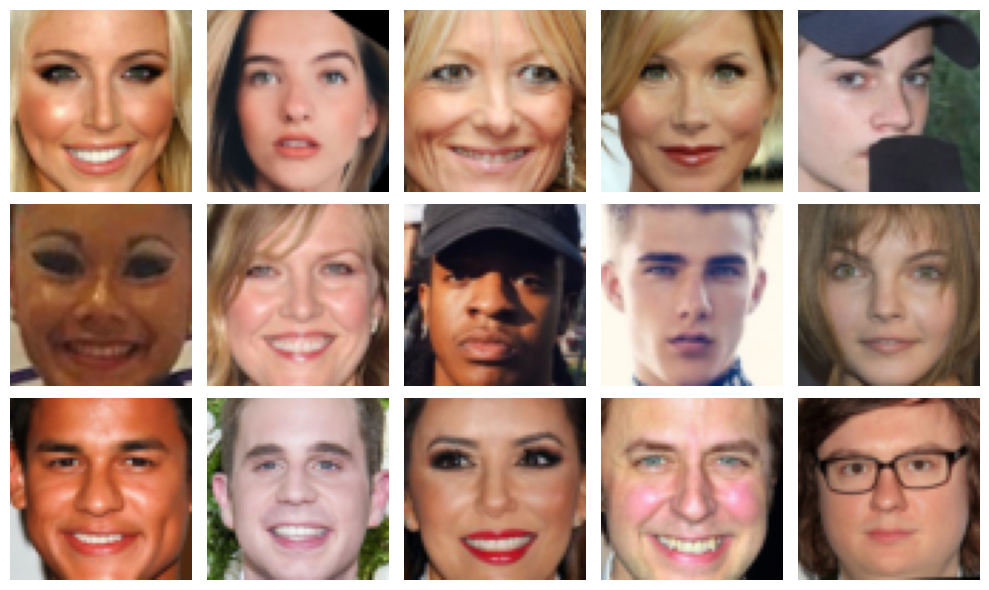

In [300]:
import random
import matplotlib.pyplot as plt

# Define el número de filas y columnas en la cuadrícula
r, c = 3, 5
# Crea una figura con el tamaño adecuado
fig = plt.figure(figsize=(2*c, 2*r))
# Llena la cuadrícula con imágenes y etiquetas
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow((X[ix].permute(1, 2, 0).numpy() / 2.0) + 0.5)  # Ajusta la transformación para llevar al rango [0, 1]
        plt.axis("off")
# Ajusta el diseño de las subfiguras y muestra la figura
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


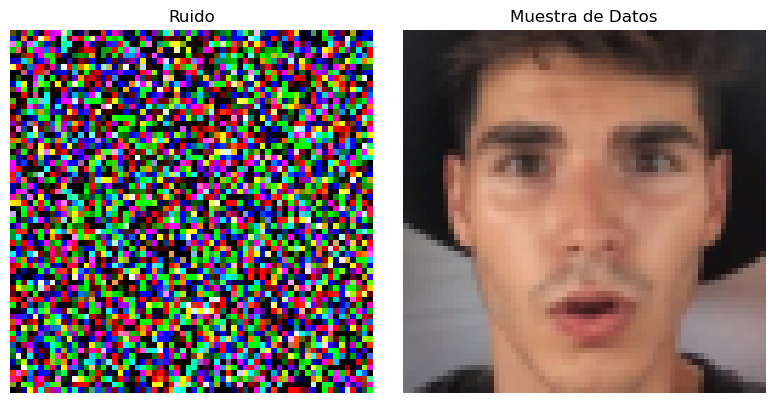

In [301]:
# Crea una figura con dos subfiguras
fig = plt.figure(figsize=(8, 4))

# Subfigura 1: Ruido
ax = plt.subplot(1, 2, 1)
noise = torch.randn(64, 64, 3)  # Cambia las dimensiones del ruido para que coincidan con el tamaño de tus imágenes
ax.imshow(noise)
ax.axis('off')
ax.set_title("Ruido")

# Subfigura 2: Muestra de tus datos
ax = plt.subplot(1, 2, 2)
sample = X[0].permute(1, 2, 0).numpy()  # Ajusta el formato de la muestra para mostrarlo correctamente
sample = (sample + 1) / 2.0  # Invierte la transformación para llevar al rango [0, 1]
ax.imshow(sample)
ax.axis('off')
ax.set_title("Muestra de Datos")

plt.tight_layout()
plt.show()

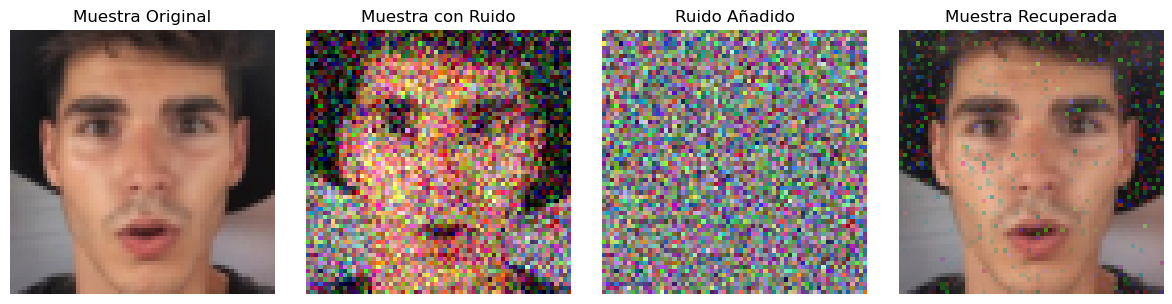

In [302]:
# Crea ruido en color
noise = torch.randn(64, 64, 3) * 0.2

# Convierte la muestra NumPy en un tensor de PyTorch
sample_tensor = torch.from_numpy(sample)

# Aplica el ruido a la muestra original
sample_with_noise = (sample_tensor + noise).clamp(0, 1)  # Asegura que los valores estén en el rango [0, 1]

# Crea una figura con cuatro subfiguras
fig = plt.figure(figsize=(12, 3))

# Subfigura 1: Muestra original
ax = plt.subplot(1, 4, 1)
ax.imshow(sample_tensor.numpy())
ax.axis('off')
ax.set_title("Muestra Original")

# Subfigura 2: Muestra con ruido
ax = plt.subplot(1, 4, 2)
ax.imshow(sample_with_noise.numpy())
ax.axis('off')
ax.set_title("Muestra con Ruido")

# Subfigura 3: Ruido añadido
ax = plt.subplot(1, 4, 3)
ax.imshow((noise + 0.5).clamp(0, 1).numpy())  # Asegura que los valores estén en el rango [0, 1]
ax.axis('off')
ax.set_title("Ruido Añadido")

# Subfigura 4: Muestra recuperada
ax = plt.subplot(1, 4, 4)
recovered_sample = (sample_with_noise - noise).clamp(0, 1)  # Asegura que los valores estén en el rango [0, 1]
ax.imshow(recovered_sample.numpy())
ax.axis('off')
ax.set_title("Muestra Recuperada")

plt.tight_layout()
plt.show()


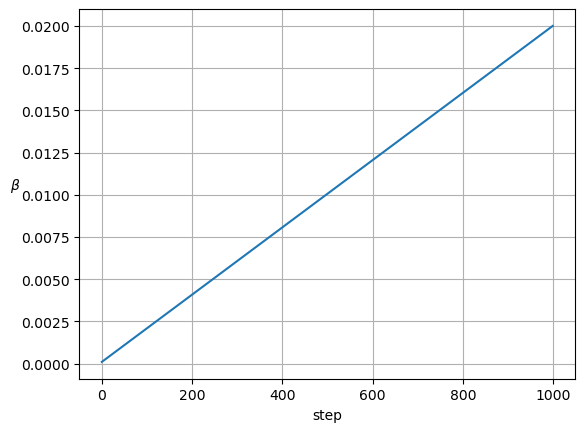

In [303]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	return torch.linspace(start, end, steps)

betas = noise_scheduler()

plt.plot(betas)
plt.xlabel('step')
plt.ylabel('$\\beta$', rotation=0)
plt.grid()
plt.show()

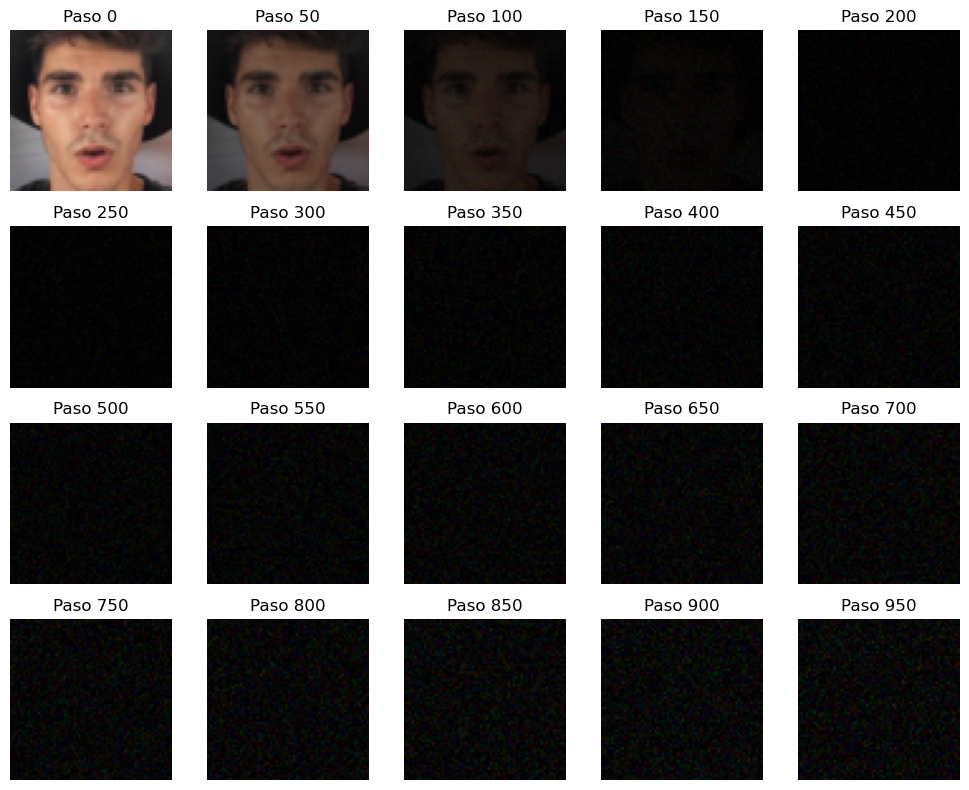

In [304]:
import torch
import matplotlib.pyplot as plt

# Inicializa la muestra con tus datos (asegúrate de que tenga la forma adecuada)
x = torch.from_numpy(sample)
#print(x.shape, betas.shape)

# Número de pasos de difusión (ajusta según sea necesario)
num_steps = 1000

# Crea una figura con subfiguras para mostrar la progresión
rs, cs = 4, 5
fig = plt.figure(figsize=(10, 8))
i = 0

# Itera a través de los pasos de difusión
for t in range(num_steps):
    x = torch.randn(64, 64, 3) * betas[t] + x * torch.sqrt(1. - torch.sqrt(betas[t]))
    
    # Asegura que los valores de píxeles estén en el rango [0, 1]
    x = torch.clamp(x, 0, 1)
    
    if t % 50 == 0:
        i += 1
        ax = plt.subplot(rs, cs, i)
        ax.imshow(x.numpy())
        ax.axis('off')
        ax.set_title(f'Paso {t}')

plt.tight_layout()
plt.show()



In [318]:
from unet import UNet
import math
import torch

class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        half_dim = dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        self.register_buffer('embeddings', embeddings)

    def forward(self, time):
        embeddings = time[:, None] * self.embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DiffusionModel(torch.nn.Module):
    def __init__(self, t_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(t_dim)
        self.unet = UNet(in_ch=3 + t_dim, out_ch=3)  # Ajusta las dimensiones de entrada y salida según tus datos

    def forward(self, x, t):
        B, C, H, W = x.shape
        t = self.time_embed(t)
        t = t[:, None, None, :].repeat(1, H, W, 1)
        x = torch.cat((x, t.permute(0, 3, 1, 2)), dim=1)  # Cambia el orden de las dimensiones de t
        return self.unet(x)

model = DiffusionModel()
output = model(torch.randn(10, 3, 64, 64), torch.randint(0, 1000, (10,)))
output.shape

ModuleNotFoundError: No module named 'unet'

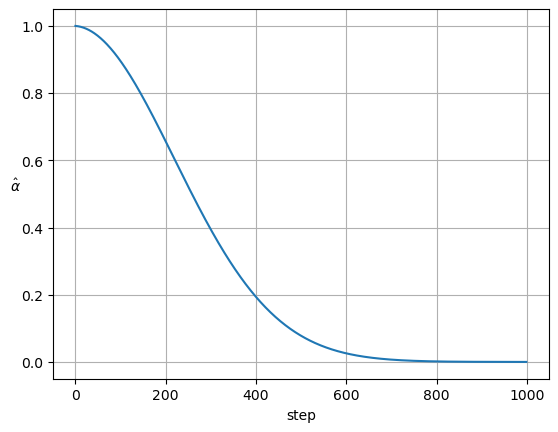

In [313]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0)
	return betas, alphas, alphas_hat

_, _, alphas_hat = noise_scheduler()

plt.plot(alphas_hat)
plt.xlabel('step')
plt.ylabel('$\\hat{\\alpha}$', rotation=0)
plt.grid()
plt.show()

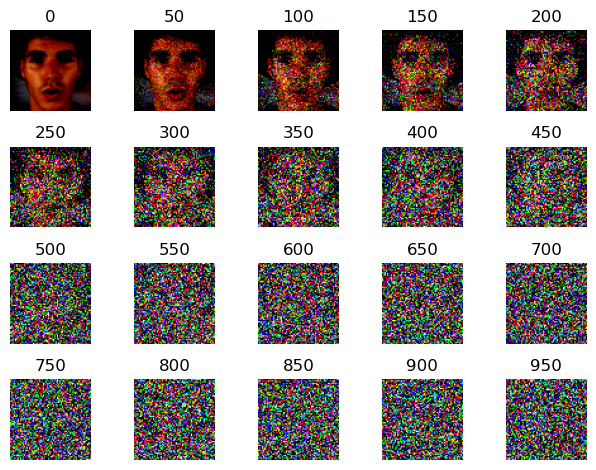

In [317]:
fig = plt.figure()
rs, cs = 4, 5

# Ajusta el número de pasos y la escala según tus datos
num_steps = 1000

sample = X[0].permute(1, 2, 0)

for i in range(rs * cs):
    ax = plt.subplot(rs, cs, i + 1)
    j = 50 * i  # Ajusta el valor inicial de j según tus necesidades
    
    # Asegura que j esté en el rango válido
    j = min(j, num_steps - 1)
    
    x = torch.randn(64, 64, 3) * torch.sqrt(1 - alphas_hat[j]) + sample * torch.sqrt(alphas_hat[j])
    x = torch.clamp(x, 0, 1)  # Asegura que los valores estén en el rango [0, 1]
    
    ax.imshow(x.numpy() )
    ax.axis('off')
    ax.set_title(j)

plt.tight_layout()
plt.show()

In [322]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, num_steps=1000):
        self.X = X
        self.num_steps = num_steps
        self.betas, _, self.alphas_hat = noise_scheduler(steps=num_steps)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        image = torch.from_numpy(self.X[ix])  # Imagen original
        t = torch.randint(0, self.num_steps, (1,))
        noise = torch.randn_like(image)  # Ruido
        x = noise * torch.sqrt(1 - self.alphas_hat[t]) + image * torch.sqrt(self.alphas_hat[t])  # Imagen con ruido
        return x.permute(2, 0, 1).float(), noise.permute(2, 0, 1).float(), t


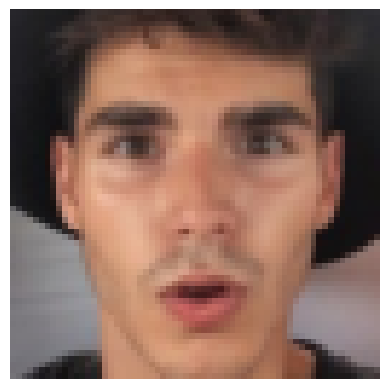

In [325]:
ds = Dataset(X) # usamos solo los 3s

plt.imshow(ds.X[0].permute(1,2,0) / 2 + 0.5)
plt.axis('off')
plt.show()

In [ ]:
img,noise,t,y = ds[1]
img.shape,noise.shape,t.shape,y.shape

(torch.Size([3, 64, 64]),
 torch.Size([3, 64, 64]),
 torch.Size([1]),
 torch.Size([1]))

In [ ]:
img.max(),img.min(),noise.max(),noise.min()

(tensor(3.5645), tensor(-3.5592), tensor(3.6054), tensor(-3.5286))

In [ ]:
t,y

(tensor([708]), tensor([0.]))

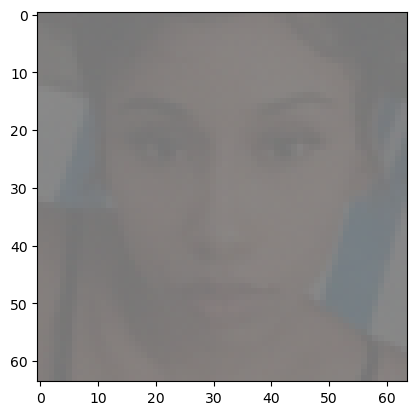

In [ ]:
plt.imshow(((img-noise+1)/2).permute(1,2,0))

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
import torch.nn as nn

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


class EncoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            conv3x3_bn(ci, co),
            conv3x3_bn(co, co),
        )
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x, t):
        x = self.conv(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class DecoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x1, x2, t):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e


class UNet2(torch.nn.Module):
    def __init__(self, out_ch=3, in_ch=1, embed_dim=32):
        super().__init__()
        # lista de capas en encoder-decoder con número de filtros
        c = [64, 128, 256, 512]
        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),
            conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = EncoderConv(c[0], c[1], embed_dim)
        self.conv3 = EncoderConv(c[1], c[2], embed_dim)
        self.conv4 = EncoderConv(c[2], c[3], embed_dim)
        # capas del decoder
        self.deconv1 = DecoderConv(c[3], c[2], embed_dim)
        self.deconv2 = DecoderConv(c[2], c[1], embed_dim)
        self.deconv3 = DecoderConv(c[1], c[0], embed_dim)
        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], out_ch, 3, padding=1)

    def forward(self, x, t):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1, t)
        x3 = self.conv3(x2, t)
        x = self.conv4(x3, t)
        # decoder
        x = self.deconv1(x, x3, t)
        x = self.deconv2(x, x2, t)
        x = self.deconv3(x, x1, t)
        x = self.out(x)
        return x

In [ ]:

class DiffusionModel2(torch.nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
        self.label_embed = torch.nn.Linear(3, embed_dim)
        self.unet = UNet2(in_ch=3, out_ch=3, embed_dim=embed_dim)

    def forward(self, x, t, y=None):
        B, C, H, W = x.shape
        t = self.time_embed(t)
        if y is not None:
            y = torch.nn.functional.one_hot(y, 3).float()
            y = self.label_embed(y)
            t = t + y
        return self.unet(x, t)

In [ ]:
im, noise, t, y = next(iter(dl))
im.shape, noise.shape, t.shape, y.shape

PicklingError: Can't pickle <function <lambda> at 0x000001AE6C9174C0>: attribute lookup <lambda> on __main__ failed

In [ ]:
sd = DiffusionModel2().cuda()
y.cuda().squeeze(-1).shape

torch.Size([])

In [ ]:
a = sd(im.cuda(),t.cuda().squeeze(-1),y.cuda().squeeze(-1))
a.shape, a.max(), a.min()

In [ ]:
EPOCHS = 40

model = DiffusionModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
    losses = []
    pb = tqdm.tqdm(dl)
    for im, noise, t, y in pb:
        im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda().squeeze(-1)
        if np.random.rand() < 0.1:
            y = None
        output = model(im, t, y)
        loss = torch.nn.functional.mse_loss(output, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')
    torch.save(model, f'DDPM_{epoch}.pt')